# ML2 Übung 3 - CNNs mit TensorFlow

In dieser Übung steht der MNIST Datensatz im Mittelpunkt. Dieser Datensatz enhält eine Klassifikationsaufgabe mit Bildern handschriftlicher Ziffern. Zunächst wird ein einfacher Klassifikator auf dem Datensatz trainiert und evaluiert. Im weiteren Verlauf wird dann ein einfaches CNN zur Klassifikation verwendet.

## MNIST Klassifikation mit linearer Regression

Zunächst werden wie üblich die benötigten Pakete eingebunden.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

Anschließend werden die MNIST Daten importiert. Bei der ersten Ausführung des nachfolgenden Codes wird der Datensatz aus dem Internet heruntergeladen.

In [2]:
# MNIST dataset can be automatically downloaded from within TensorFlow
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)    # labels are encoded as one-hot!

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Der MNIST Datensatz besteht aus Trainings-, Validierungs- und Testdaten: 

In [102]:
print("Train Set Shape: " + str(np.shape(mnist.train.images)))
print("Validation Set Shape: " + str(np.shape(mnist.validation.images)))
print("Test Set Shape: " + str(np.shape(mnist.test.images)))

Train Set Shape: (55000, 784)
Validation Set Shape: (5000, 784)
Test Set Shape: (10000, 784)


Wie sehen die Daten von MNIST eigentlich aus? 

Hier einige Beispiele aus dem Trainingsdatensatz:

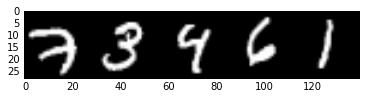

In [103]:
import numpy as np
img0 = mnist.train.images[0].reshape([28,28])
img1 = mnist.train.images[1].reshape([28,28])
img2 = mnist.train.images[2].reshape([28,28])
img3 = mnist.train.images[3].reshape([28,28])
img4 = mnist.train.images[4].reshape([28,28])
plt.imshow(np.concatenate((img0, img1, img2, img3, img4), axis=1))
plt.gray()
plt.show()

Zu den Daten existieren natürlich auch die entsprechenden Labels. Hier die Labels zu den dargestellten Beispielbildern aus dem Trainingsdatensatz:

In [104]:
print("Train Labels: \n" + str(mnist.train.labels[0:5]))


Train Labels: 
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


Analog zu Übung 2: Definition des Tensorflow Graphen: 

In [105]:
# Define placeholders for input data and labels (with arbitrary batch size)
x = tf.placeholder(tf.float32, shape=[None, 784], name='x')    # input as vector of size 28*28 = 784
y = tf.placeholder(tf.float32, shape=[None, 10], name='y')    # labels as numbers 0 - 9

# Define variables for the graph and initialize them
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))


In diesem Fall wird ein Softmax Loss verwendet:

In [106]:
with tf.name_scope('Loss') as scope:
    y_pred = tf.matmul(x, W) + b
    softmax = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_pred))

In [107]:
learning_rate = 0.05
with tf.name_scope('optimizer') as scope:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(softmax)

Nachdem der Graph definiert wurde, kann nun das Training gestartet werden. Im Gegensatz zu Übung 2 wird an dieser Stelle nicht mehr der gesamte Datensatz in jedem Trainingsschritt verwendet. Pro Schritt wird lediglich ein kleiner Teil der Daten verwendet (auch batch oder min-batch genannt). Im MNIST Beispiel von Tensorflow wird bereits eine Funktion zur Verfügung gestellt, die aus den Trainingsdaten in jedem Trainingsschritt eine definierte Anzahl Bilder bereitstellt.

In [113]:
steps = 2000
batch_size = 100
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    for _ in range(steps):
        batch = mnist.train.next_batch(batch_size)
        optimizer.run(feed_dict={x: batch[0], y: batch[1]})

Nachdem der Klassifikator trainiert wurde, kann er nun auf die Testdaten angewandt werden:

In [115]:
with tf.Session() as sess:
    init.run()
    # Define test data to be fed into graph
    test_data = { x: mnist.test.images, y: mnist.test.labels }

    prediction = tf.argmax(y_pred, 1)
    label = tf.argmax(y, 1)

    # Calculate whether a prediction is correct or not
    correct_prediction = tf.equal(prediction, label)
    print(correct_prediction.eval(feed_dict=test_data))
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Klassifikationsrate: " + str(accuracy.eval(feed_dict=test_data)))

[False False False ..., False False False]
Genauigkeit: 0.098


Dies entspricht nicht ganz dem erwarteten Ergebnis. Weshalb wird hier ein so schlechtes Ergebnis erreicht? Nachfolgend werden Training und Test des Modells gemeinsam durchgeführt:

In [116]:
steps = 2000
batch_size = 100
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    for _ in range(steps):
        batch = mnist.train.next_batch(batch_size)
        optimizer.run(feed_dict={x: batch[0], y: batch[1]})
        
    # Define test data to be fed into graph
    test_data = { x: mnist.test.images, y: mnist.test.labels }

    prediction = tf.argmax(y_pred, 1)
    label = tf.argmax(y, 1)

    # Calculate whether a prediction is correct or not
    correct_prediction = tf.equal(prediction, label)
    print(correct_prediction.eval(feed_dict=test_data))
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Klassifikationsrate: " + str(accuracy.eval(feed_dict=test_data)))

[ True  True  True ...,  True  True  True]
Genauigkeit: 0.9094


Hier wird nun ein deutlich besseres Ergebnis erreicht. Im ersten Durchlauf wurde nicht bedacht, dass das trainierte Modell nach Ende der Session verworfen wird. Bei Erstellung der Evaluationssession werden die Gewichte des Modells neu initialisiert und die Evaluation darauf durchgeführt.

Um dies zu verhindern sollte das Modell nach dem Training vor dem Beenden der Session gespeichert werden. Zur Evaluation kann es dann innerhalb der Evaluationssession wieder geladen werden. Somit sind Training und Evaluation zeitlich entkoppelt und das Modell verbleibt zur späteren Verwendung gespeichert.

In [117]:
steps = 2000
batch_size = 100
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for _ in range(steps):
        batch = mnist.train.next_batch(batch_size)
        optimizer.run(feed_dict={x: batch[0], y: batch[1]})
    saver.save(sess, "/tmp/model.ckpt")

In [119]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/model.ckpt")
    # Define test data to be fed into graph
    test_data = { x: mnist.test.images, y: mnist.test.labels }

    prediction = tf.argmax(y_pred, 1)
    label = tf.argmax(y, 1)

    # Calculate whether a prediction is correct or not
    correct_prediction = tf.equal(prediction, label)
    print(correct_prediction.eval(feed_dict=test_data))
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Klassifikationsrate: " + str(accuracy.eval(feed_dict=test_data)))

[ True  True  True ...,  True  True  True]
Genauigkeit: 0.9106


Das Modell kann nun auch zur Klassifikation einzelner Eingabebilder genutzt werden. Nachfolgend wir ein zufälliges Bild aus dem MNIST Testdatensatz ausgewählt und angezeigt:

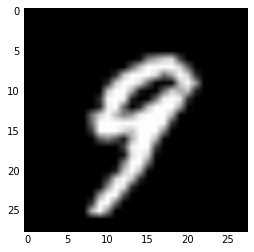

In [125]:
import random
img = random.choice(mnist.test.images)
plt.imshow(img.reshape([28,28]))
plt.gray()
plt.show()

Auf dieses Bild kann nun der Klassifikator angewandt werden. Mit folgendem Code wird zunächst das gelernte Modell geladen und danach auf das Bild angewendet. Die resultierende Verteilund und somit die vorhergesagte Klasse kann beispielsweise in einem Balkendiagramm ausgegeben werden:

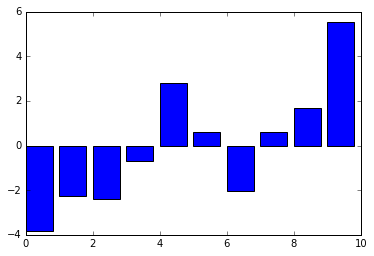

In [126]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/model.ckpt")
    plt.bar(range(10), y_pred.eval(feed_dict={x: [img] })[0])
    plt.show()

### Interactive Sessions

Falls all diese Schritte in einer Umgebung wie den Jupyter Notebooks ausgeführt werden, existiert in Tensorflow auch eine interaktive Session. Hiermit wird zu Beginn eine Session definiert und für den weiteren Verlauf als Standard-Session verwendet. Ein Speichern und Laden von Modellen ist so nicht mehr nötig:  

In [135]:
sess = tf.InteractiveSession()

In [136]:
tf.global_variables_initializer().run()

In [133]:
sess.run(tf.global_variables_initializer())

In [137]:
steps = 20000
batch_size = 100

for i in range(steps):
    batch = mnist.train.next_batch(batch_size)
    sess.run(optimizer, feed_dict={x: batch[0], y: batch[1]})

In [138]:
# Define test data to be fed into graph
test_data = { x: mnist.test.images, y: mnist.test.labels }

prediction = tf.argmax(y_pred, 1)
label = tf.argmax(y, 1)

# Calculate whether a prediction is correct or not
correct_prediction = tf.equal(prediction, label)
print(correct_prediction.eval(feed_dict=test_data))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Klassifikationsrate: " + str(accuracy.eval(feed_dict=test_data)))

[ True  True  True ...,  True  True  True]
Klassifikationsrate: 0.9227


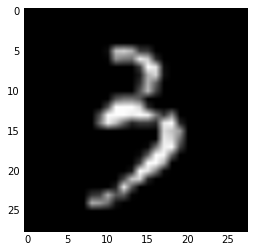

In [140]:
import random
img = random.choice(mnist.test.images)
plt.imshow(img.reshape([28,28]))
plt.gray()
plt.show()

In [139]:
# Determine fraction of correct predictions given the true label
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print accuracy.eval(feed_dict=test_data)

0.9227


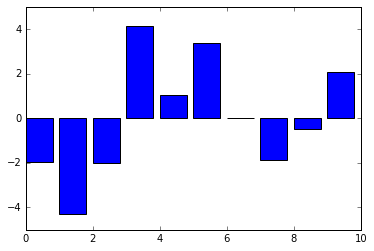

In [141]:
plt.bar(range(10), y_pred.eval(feed_dict={x: [img] })[0])
plt.show()

Nach Ende der Verwendung sollte auch die interaktive Session wieder geschlossen werden:

In [30]:
print(y_pred.eval(feed_dict={x: [img]}))

[[  0.64392018   2.81098771  14.22045708   7.95471954 -14.39821625
    1.78300774   5.14748096 -11.35773945   2.39862823  -9.20321465]]


In [142]:
sess.close()

## MNIST Klassifikation mit CNNs

Zunächst sollte die Umgebung aufgeräumt werden:

In [143]:
tf.reset_default_graph()

Danach wird eine neue interaktive Session gestartet:

In [3]:
sess = tf.InteractiveSession()

Nun wird der TensorFlow Graph mit mit der CNN Architektur erstellt:

In [4]:
# Define placeholders for input data and labels (with arbitrary batch size)
x = tf.placeholder(tf.float32, shape=[None, 784])    # input as vector of size 28*28 = 784
y = tf.placeholder(tf.float32, shape=[None, 10])    # labels as numbers 0 - 9

In [5]:
# Define functions to create layers
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

#### Eingabeschicht:

In [6]:
# Transform MNIST images to 4-dimensional tensor:
#[MiniBatch, x, y, color_channels]
x_image = tf.reshape(x, [-1,28,28,1])

#### Erste Schicht: Convolution (32 Filter der Größe 5x5):

In [7]:
# Filter size: 5x5, color channels: 1, number of filters: 32
W_conv1 = tf.Variable(tf.truncated_normal(shape=[5, 5, 1, 32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32]))

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

#### Zweite Schicht: MaxPooling (2x2)

In [8]:
h_pool1 = max_pool_2x2(h_conv1)

#### Dritte Schicht: Convolution (64 Filter der Größe 5x5):

In [9]:
# Filter size: 5x5, input size: 32, number of filters: 64
W_conv2 = tf.Variable(tf.truncated_normal(shape=[5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

#### Vierte Schicht: MaxPooling (2x2)

In [10]:
h_pool2 = max_pool_2x2(h_conv2)

Nachfolgend zwei Fully Connected Layer (3136 und 1024 Neuronen):

In [11]:
# Fully connected layer
W_fc1 = tf.Variable(tf.truncated_normal(shape=[7 * 7 * 64, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [12]:
# Add classification layer at the end
W_fc2 = tf.Variable(tf.truncated_normal(shape=[1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))

y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2

# Use softmax loss (just as before!)
softmax = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_conv))

#### Training

Zum Trainieren des Netzes wird an dieser Stelle der Adam Optimizer verwendet. Gradient Descent würde an dieser Stelle auch funktionieren. In den letzten Jahren hat sich allerdings gezeigt, dass Adam bei größeren Netzen schneller bessere Ergebnisse erreicht.

In [13]:
learning_rate = 0.0001
steps = 100

adam_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(softmax)

Ist das Netz definiert, kann das Training gestartet werden. Hierbei ist zu Beachten, dass das Netz bereits eine gewisse Größe erreicht hat. Deshalb muss mit einer deutlich längeren Trainingslaufzeit als bei den bisher ausgeführten Trainings gerechnet werden. An diesem Punkt stellt sich zum ersten Mal die Frage, ob nicht eine Auslagerung des Trainings auf eine Grafikkarte sinnvoll wäre. Hierzu müsste lediglich die gpu Version von Tensorflow im Virtualenv installiert werden.

In [26]:
batch_size = 50

# Calculate whether a prediction is correct or not
# This time we can include it in the training loop to check progress 
# during training on training data.
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

tf.global_variables_initializer().run()

for i in range(steps):
    batch = mnist.train.next_batch(batch_size)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y: batch[1]})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    #Aufgabe:
    #Ergänzen sie an dieser Stelle den zentralen Befehl zum Training des Netzes

step 0, training accuracy 0.12


#### Evaluation

In [27]:
print("Klassifikationsrate %g" % accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))

Klassifikationsrate 0.1021


#### Klassifikation

Nachfolgend soll wieder ein zufälliges Bild aus dem Trainingsdatensatz gewählt werden.

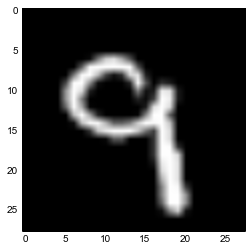

In [28]:
import random
img = random.choice(mnist.test.images)
plt.imshow(img.reshape([28,28]))
plt.gray()
plt.show()

Auf dieses Bild kann nun das trainierte Modell angewandt werden. Die Ausgabe des Netzes werden anschließend in Form eines Balkendiagrammes ausgegeben.

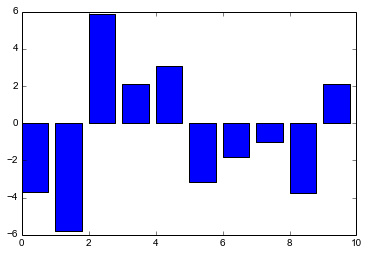

In [30]:
plt.bar(range(10), y_conv.eval(feed_dict={x: [img] })[0])
plt.show()